In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', weights=None)
model = model.to(device)


Using cache found in C:\Users\sebas/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
model


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
download = False

# Check if "cifar-10-batches-py" exists
if not os.path.isdir('./data/cifar-10-batches-py'):
    download = True

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


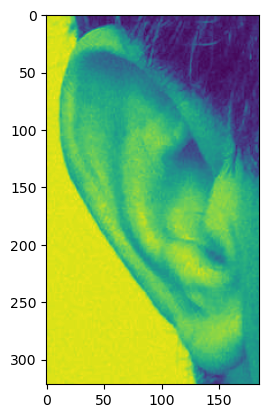

In [10]:
im = cv2.cvtColor(cv2.imread("./data/AWE/001/01.png"), cv2.COLOR_BGR2GRAY)
plt.imshow(im)


### Read in data

In [125]:
ear_data = os.listdir("./data/AWE")
ear_data

ear_imgs = {}
for person in ear_data:
    ear_imgs[person] = [cv2.cvtColor(cv2.imread("./data/AWE/%s/%02d.png" % (person, i)), cv2.COLOR_BGR2RGB) for i in range(1, 11)]


### Preprocess input data

In [118]:
from PIL import Image
import copy


In [126]:
def resize_input(input_data: dict, tgt_size=224) -> dict:
    resized_data = copy.deepcopy(input_data)
    for key in input_data.keys():   # For each person
        for i in range(len(input_data[key])):   # For each image
            # Resize into 224x448
            resized_data[key][i] = np.array(Image.fromarray(resized_data[key][i]).resize((tgt_size, 2*tgt_size)))
            
            # Zero pad to make it square
            pad = np.abs(resized_data[key][i].shape[1] - resized_data[key][i].shape[0]) // 2
            resized_data[key][i] = np.pad(resized_data[key][i], ((0, 0), (pad, pad), (0, 0)), 'constant')    
            
            resized_data[key][i] = cv2.cvtColor(resized_data[key][i], cv2.COLOR_RGB2GRAY)
    return resized_data


input_data = resize_input(ear_imgs)


(448, 448)

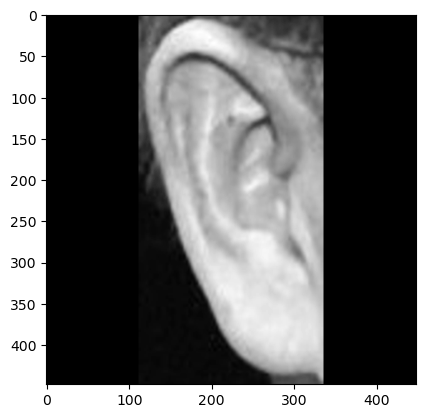

In [127]:
# plt.imshow(ear_imgs['051'][6])
plt.imshow(input_data['011'][3], cmap='gray')
input_data['011'][3].shape  


### Test train split across all persons
Split within a single person

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test = [], [] 


for person, imgs in ear_imgs.items():
    #_X_train, _X_test = train_test_split(imgs, test_size=0.3, random_state=42)
    _X_train, _X_test = imgs[:7], imgs[7:]
    X_train.append(_X_train)
    X_test.append(_X_test)


In [60]:
with open("data/train_dataset", "w") as fp:
    fp.write(str(X_train))
    
with open("data/test_dataset", "w") as fp:
    fp.write(str(X_test))


### Train the model

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

batch_size = 32
n_epochs = 10
lr = 0.001
n_classes = len(X_train)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [69]:
for epoch in range(n_epochs):
    model.train()
    r_loss = 0
    for i, inputs in enumerate(X_train):
        inputs, labels = torch.Tensor(inputs).to(device), i.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        r_loss += loss.item()


ValueError: expected sequence of length 322 at dim 1 (got 76)

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


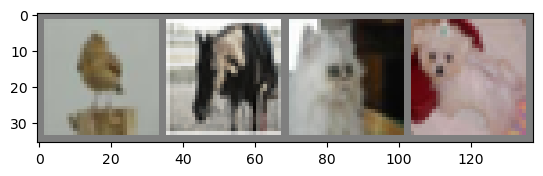

bird  horse cat   dog  


In [13]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


Define neural network

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)


Define loss function and optimizer

In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)


Train network

In [36]:
epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # Deconstruct data - images, labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')


[1,  2000] loss: 2.305
[1,  4000] loss: 2.305
[1,  6000] loss: 2.304
[1,  8000] loss: 2.305
[1, 10000] loss: 2.304
[1, 12000] loss: 2.304
[2,  2000] loss: 2.305
[2,  4000] loss: 2.304
[2,  6000] loss: 2.305
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
[2, 12000] loss: 2.306
Finished Training


In [ ]:
# Store model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


In [ ]:
# Load net
net = Net()
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

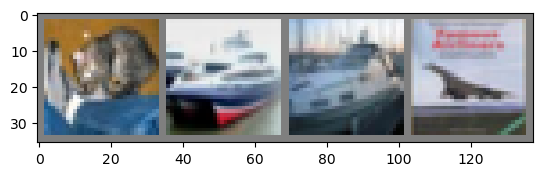

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  cat   plane car   plane


In [ ]:
# Test on whole dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 54 %
